#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

**Описание данных**

- datetime - дата и время заказов
- num_orders - количество заказов


**План работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
# импортируем библиотеки 

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, cv, CatBoostRegressor
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.simplefilter("ignore")
import warnings
warnings.filterwarnings("ignore")

from numpy.random import RandomState
STATE = RandomState(12345)


In [2]:
# загрузим данные 

try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    
data.sort_index(inplace=True)
data


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
# посмотрим какие данные у нас в таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

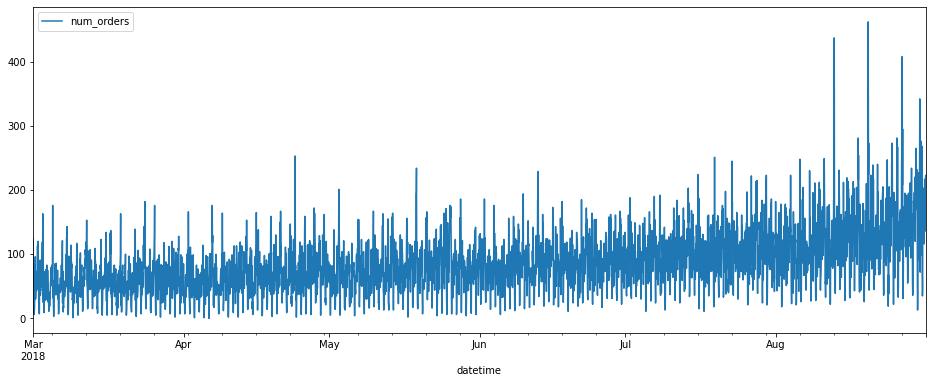

In [4]:
# проведем ресемплирование

data = data.resample('1H').sum()


data.plot(figsize=(16,6))

**Вывод**

Таблица состоит из двух столбцов и 26 496 строк, пропусков нет. Первый столбец с датой используем как индексы. Провели ресемплирование данных по часам. 

## Анализ

<AxesSubplot:xlabel='datetime'>

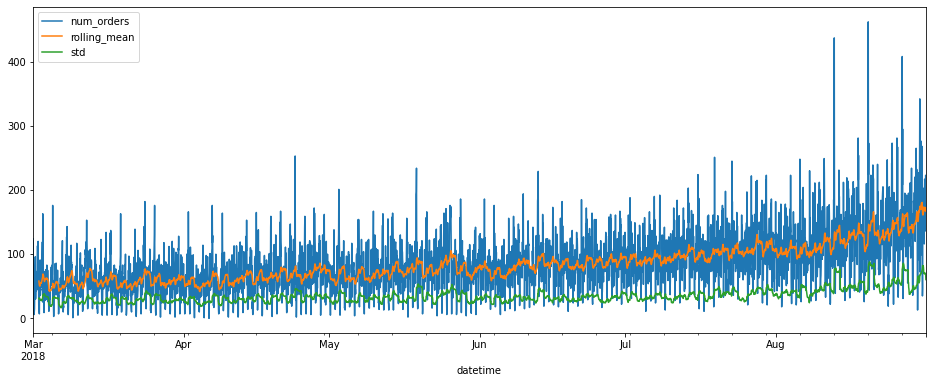

In [5]:
# посмотрим на скользящее среднее и стандартное отклонение

df = data.copy()
df['rolling_mean'] = df['num_orders'].rolling(30).mean()
df['std'] = df['num_orders'].rolling(30).std()
df.plot(figsize=(16,6))

- **по графику видно, что ряд нестационарный**

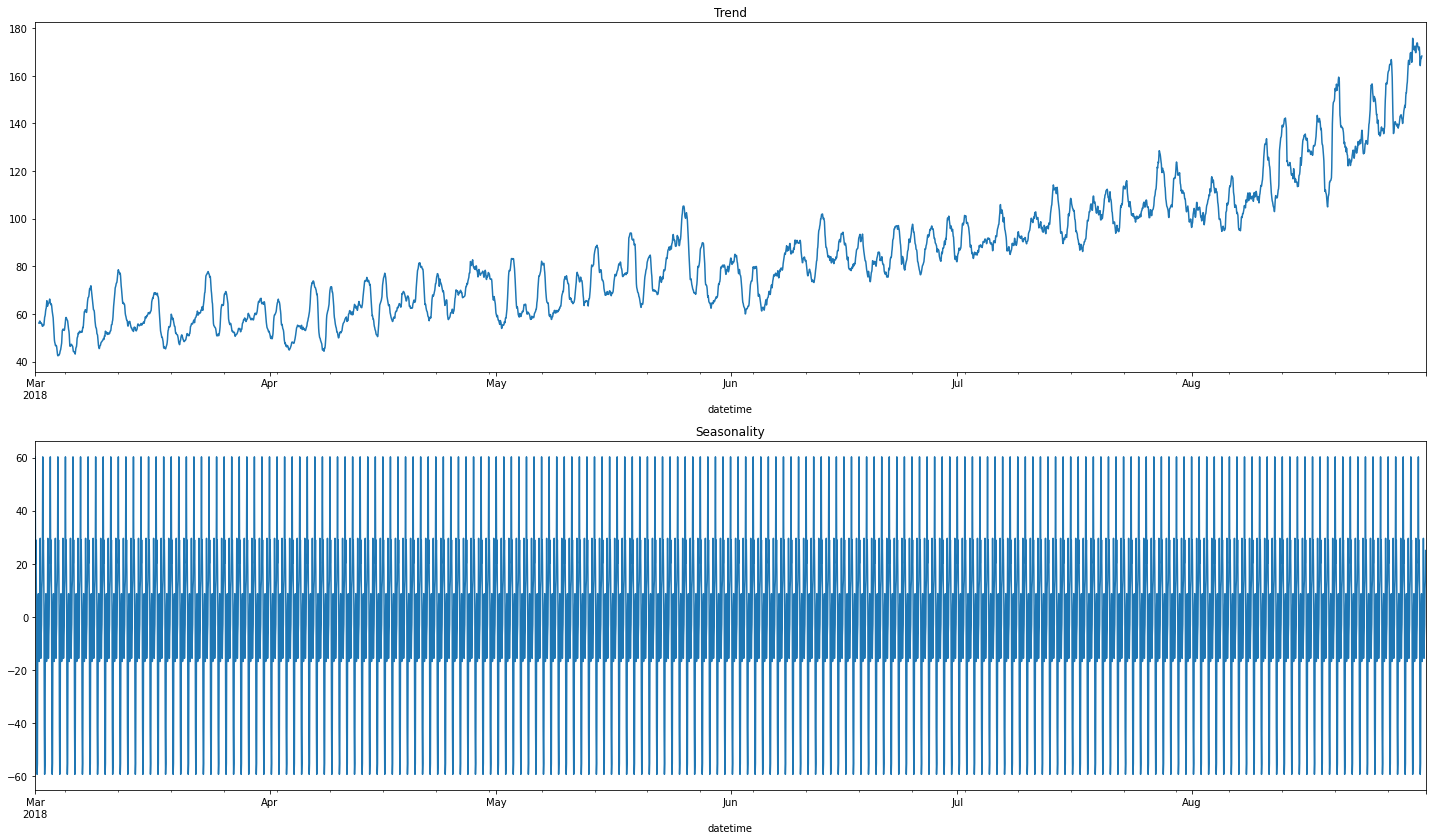

In [6]:
# посмотрим на сезонность и тренды

data_dec = data['2018-03':'2018-08'].resample('1H').sum()

decomposed = seasonal_decompose(data_dec)

plt.figure(figsize=(20, 17))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()


- **По графику тренда видно, что количество заказов растет к лету.**
- **Сезонность с периодом меньше месяца.**

<AxesSubplot:xlabel='datetime'>

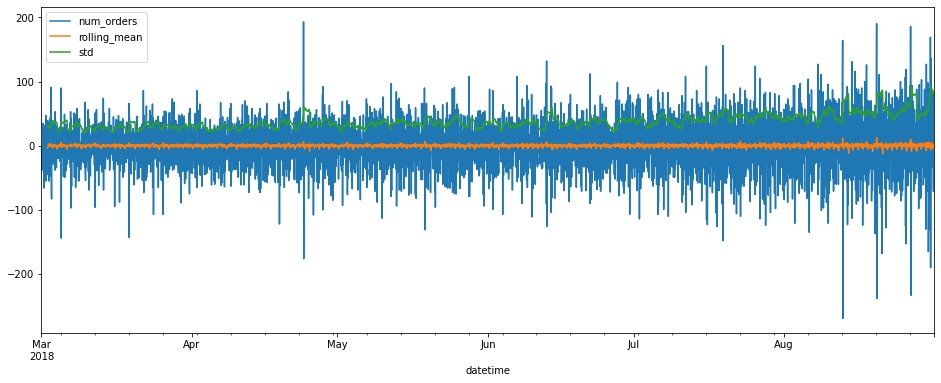

In [7]:
# сделаем наш ряд более стационарным

data = data - data.shift()
data['rolling_mean'] = data['num_orders'].rolling(30).mean()
data['std'] = data['num_orders'].rolling(30).std()
data.plot(figsize=(16,6))

- **график выглядит лучше, можем строить прогнозы**

## Обучение

In [8]:
# напишем функцию расчета RMSE

def RMSE(predictions, target):
    rmse = MSE(predictions, target) ** 0.5
    return rmse

# подготовим rmse для расчетов в моделях
rmse_score = make_scorer(RMSE, greater_is_better=False)


In [9]:
# создазим признаки

data_new = data.copy()

def make_features(data, max_lag, rolling_mean_size):
    
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

make_features(data, 24, 2)
display(data_new.head())


,num_orders,rolling_mean,std,year,month,day,dayofweek,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN,2018,3,1,3,-39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,-26.5,NaN,2018,3,1,3,-14.0,-39.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,-9.5,NaN,2018,3,1,3,-5.0,-14.0,-39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# поделим данные на признаки и правильные ответы

train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']


In [11]:
# подготовим необходимые параметры для GridSearchCV

pipe = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=STATE))
])

params = [
    {
        'imp__strategy': ['mean', 'median'],
        'model': [RandomForestRegressor(n_estimators=31, random_state=STATE)],
        'model__max_features': np.linspace(0.1, 1, 11)
    }, {
        'imp__strategy': ['mean', 'median'],
        'model': [LinearRegression()]
    }, {
        'imp__strategy': ['mean', 'median'],
        'model': [Lasso(random_state=STATE)],
        'model__alpha': np.logspace(-1, 3, 10)
    }, {
        'imp__strategy': ['mean', 'median'],
        'model': [DecisionTreeRegressor(random_state=STATE)],
        'model__max_depth': range(2, 41)
    }
]


In [12]:

cv = TimeSeriesSplit(n_splits=5, gap=0)
grid = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=rmse_score)


In [13]:
# посмотрим, что покажет GridSearchCV

grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=RandomState(MT19937) at 0x7F2A0D712940))]),
             n_jobs=-1,
             param_grid=[{'imp__strategy': ['mean', 'median'],
                          'model': [RandomForestRegressor(n_estimators=3...
                          'model__alpha': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03])},
                         {'imp__strategy': ['mean', 'median'],
                          'model': [DecisionTreeRegressor(random_state=RandomState(MT19937) at 0x7F2A0D712940)],
                          'model__max_depth'

In [14]:
print('Best Params:', grid.best_params_)
print('Best RMSE Score:', -grid.best_score_)

Best Params: {'imp__strategy': 'mean', 'model': Lasso(alpha=0.1, random_state=RandomState(MT19937) at 0x7F2A0D712940), 'model__alpha': 0.1}
Best RMSE Score: 27.498666604178663


- **GridSearchCV показал лучший результат у Lasso. RMSE - 27.49**

In [15]:
# проверим работу CatBoostRegressor

cat = CatBoostRegressor()

cat.fit(features_train, target_train, eval_set=(features_train, target_train), verbose=False, plot=True);


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

- **лучший результат RMSE у CatBoostRegressor - 10.47**

In [16]:
# выведем параметры которые использовали в CatBoostRegressor

for key,value in cat.get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, RMSE
iterations, 1000
sampling_frequency, PerTree
leaf_estimation_method, Newton
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, True
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.800000011920929
use_best_model, True
random_seed, 0
depth, 6
posterior_sampling, False
border_count, 254
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, RMSE
learning_rate, 0.06316199898719788
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_type, MVS
max_leaves, 64


In [17]:
# подберем параметры для LGBMRegressor

lgbm = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 20, 40], 
    'num_leaves': [5, 15, 31]
}

grid_lgbm = GridSearchCV(lgbm, param_grid)

grid_lgbm.fit(features_train, target_train)

print('Best parameters found by grid search are:', grid_lgbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 40, 'num_leaves': 31}


In [18]:
# проверим работу LGBMRegressor с нашими параметрами на обучающей выборке

lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_test, target_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'regression', 
    'metric': {'l2', 'RMSE'}, 
    'num_leaves': 31, 
    'learning_rate': 0.1, 
    'n_estimators': 40
}

lgbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_train, early_stopping_rounds=5)
predictions = lgbm.predict(features_train, num_iteration=lgbm.best_iteration)
rmse_res = RMSE(target_train, predictions)

print('The rmse of prediction is:', rmse_res)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4961
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 29
[LightGBM] [Info] Start training from score 0.027383
[1]	training's rmse: 34.9556	training's l2: 1221.89
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 33.8976	training's l2: 1149.05
[3]	training's rmse: 32.9512	training's l2: 1085.78
[4]	training's rmse: 32.1204	training's l2: 1031.72
[5]	training's rmse: 31.3336	training's l2: 981.792
[6]	training's rmse: 30.6642	training's l2: 940.293
[7]	training's rmse: 30.0144	training's l2: 900.864
[8]	training's rmse: 29.4587	training's l2: 867.814
[9]	training's rmse: 28.9241	training's l2: 836.602
[10]	training's rmse: 28.4369	training's l2: 808.658
[11]	training's rmse: 27.9766	training's l2: 782.688
[12]	training's rmse: 

- **на LGBMRegressor получили RMSE - 20.65**

## Тестирование

In [19]:
# посмотрим на результат работы Lasso на тестовой выборке

model_lasso = Lasso(random_state=STATE, alpha=0.1)
model_lasso.fit(features_train, target_train)
prediction_lasso = model_lasso.predict(features_test)
result_lasso = RMSE(prediction_lasso, target_test)


print(f'RMSE: {result_lasso}')

RMSE: 44.91421355153024


- **Лучший показатель RMSE на Lasso - 44.91**

In [20]:
# проверим CatBoostRegressor на тестовой выборке

cat_model = CatBoostRegressor(loss_function='RMSE', 
                        iterations=1000, 
                        learning_rate=0.06, 
                        max_depth=6, 
                        l2_leaf_reg=3, 
                        max_leaves=64)

cat_model.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=False, plot=True);


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

- **Лучший показатель RMSE на CatBoostRegressor - 45.06**

In [21]:
# проверим LGBMRegressor на тестовой выборке

lgbm_1 = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=5)
predictions_lgbm = lgbm_1.predict(features_test, num_iteration=lgbm_1.best_iteration)
result_lgbm = RMSE(target_test, predictions_lgbm)

print('The rmse of prediction is:', result_lgbm)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4961
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 29
[LightGBM] [Info] Start training from score 0.027383
[1]	valid_0's rmse: 57.8273	valid_0's l2: 3344
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 56.9956	valid_0's l2: 3248.49
[3]	valid_0's rmse: 56.2638	valid_0's l2: 3165.61
[4]	valid_0's rmse: 55.7641	valid_0's l2: 3109.63
[5]	valid_0's rmse: 55.1289	valid_0's l2: 3039.2
[6]	valid_0's rmse: 54.6146	valid_0's l2: 2982.75
[7]	valid_0's rmse: 54.1229	valid_0's l2: 2929.29
[8]	valid_0's rmse: 53.7142	valid_0's l2: 2885.21
[9]	valid_0's rmse: 53.4381	valid_0's l2: 2855.63
[10]	valid_0's rmse: 53.0922	valid_0's l2: 2818.78
[11]	valid_0's rmse: 52.7365	valid_0's l2: 2781.13
[12]	valid_0's rmse: 52.478	valid_0's l2: 2753.9

- **Лучший показатель RMSE на LGBMRegressor - 49.20**

Text(0.5, 1.0, 'Targets')

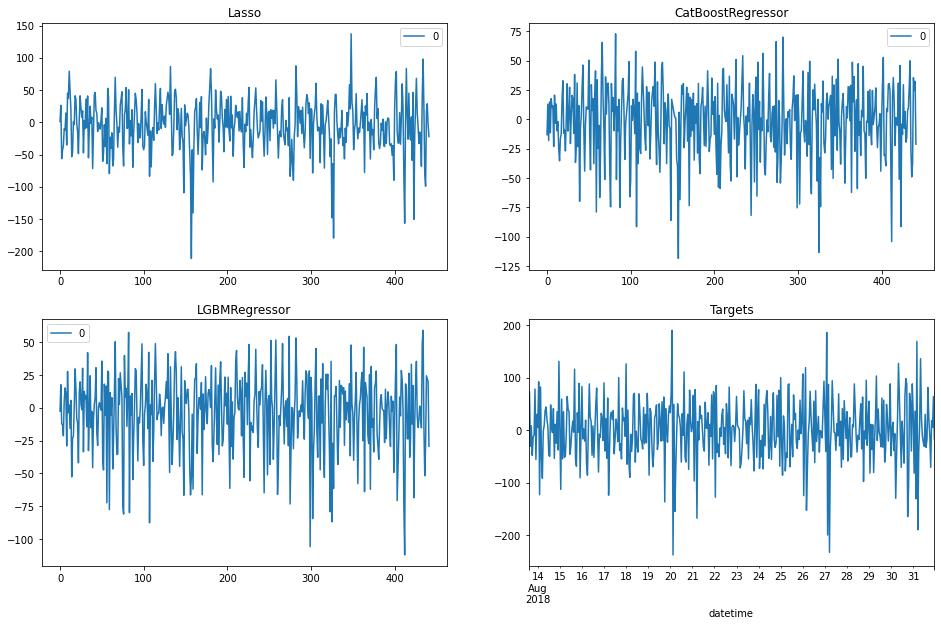

In [23]:
# построим графики предсказаний по каждой модели и целевых признаков

prediction_lasso = pd.DataFrame(prediction_lasso)
prediction_cat = pd.DataFrame(cat_model.predict(features_test))
predictions_lgbm = pd.DataFrame(predictions_lgbm)


plt.figure(figsize=(16, 10))

plt.subplot(221)
prediction_lasso.plot(ax=plt.gca())
plt.title('Lasso')

plt.subplot(222)
prediction_cat.plot(ax=plt.gca())
plt.title('CatBoostRegressor')

plt.subplot(223)
predictions_lgbm.plot(ax=plt.gca())
plt.title('LGBMRegressor')

plt.subplot(224)
target_test.plot(ax=plt.gca())
plt.title('Targets')


- **График предсказаний Lasso более похож на график целевых признаков тестовой выборки**

- **Лучший показатель RMSE на Lasso - 44.91**

- **Лучший показатель RMSE на CatBoostRegressor - 45.06**

- **Лучший показатель RMSE на LGBMRegressor - 49.20**

## Общий вывод

В процессе выбора моделей для прогнозирования заказов такси, мы протестировали три модели и расчитали показатель RMSE на каждой:

- Lasso - 44.91;
- CatBoostRegressor - 45.06;
- LGBMRegressor - 49.20 (нам не подходит).

Рекомендуется использовать Lasso так как у этой модели самый низкий показатель RMSE на тестовой выборке.
